In [152]:
import os
import sklearn
import numpy as np
from numpy import unwrap, diff, abs, angle
import pandas as pd
import seaborn as sns
import tensorflow as tf
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from scipy.signal import hilbert
from sklearn.utils import shuffle
import scipy
from scipy.signal import butter, filtfilt, hilbert
from scipy.interpolate import interp1d
from scipy.interpolate import CubicSpline
from tensorflow.keras.models import Sequential
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.layers import Dense,  BatchNormalization, Dropout
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
import mne
from mne.preprocessing import ICA
import pywt
from scipy.stats import skew, kurtosis
from scipy.signal import spectrogram

Preproccesing Functions

In [153]:
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = filtfilt(b, a, data)
    return y

def denoise_data(df, col_names, n_clusters):
    df_denoised = df.copy()
    for col_name, k in zip(col_names, n_clusters):
        df_denoised[col_name] = pd.to_numeric(df_denoised[col_name], errors='coerce') # Convert column to numeric format
        X = df_denoised.select_dtypes(include=['float64', 'int64']) # Select only numeric columns
        clf = KNeighborsRegressor(n_neighbors=k, weights='uniform') # Fit KNeighborsRegressor
        clf.fit(X.index.values[:, np.newaxis], X[col_name])
        y_pred = clf.predict(X.index.values[:, np.newaxis]) # Predict values 
        df_denoised[col_name] = y_pred
    return df_denoised

def z_score(df, col_names):
    df_standard = df.copy()
    for col in col_names:
        df_standard[col] = (df[col] - df[col].mean()) / df[col].std()
    return df_standard

def custom_detrend(df, col_names):
    df_detrended = df.copy()
    for col in col_names:
        y = df_detrended[col]
        x = np.arange(len(y))
        p = np.polyfit(x, y, 1)
        trend = np.polyval(p, x)
        detrended = y - trend
        df_detrended[col] = detrended
    return df_detrended

def preprocess(df, col_names, n_clusters):
    df_new = df.copy()
    df_new = denoise_data(df, col_names, n_clusters)
    df_new = z_score(df_new, col_names)
    df_new = custom_detrend(df_new, col_names)
    return df_new

def df_to_raw(df, sfreq=250):
    info = mne.create_info(ch_names=list(df.columns), sfreq=sfreq, ch_types=['eeg'] * df.shape[1])
    raw = mne.io.RawArray(df.T.values * 1e-6, info)  # Converting values to Volts from microvolts for MNE
    return raw

def reject_artifacts(df, channel):
    threshold_factor = 3
    median = df[channel].median()
    mad = np.median(np.abs(df[channel] - median))
    spikes = np.abs(df[channel] - median) > threshold_factor * mad
    x = np.arange(len(df[channel]))
    cs = CubicSpline(x[~spikes], df[channel][~spikes]) # Interpolate using Cubic Spline
    interpolated_values = cs(x)
    interpolated_values[spikes] *= 0.1  # Make interpolated values 0.1 times smaller
    # Check each interpolated value's difference from median and compare to the threshold
    spike_values = np.abs(interpolated_values - median) > threshold_factor * mad
    interpolated_values[spike_values] *= 0.01 
    df[channel] = interpolated_values
    return df


Define the dataset

(10000, 8)


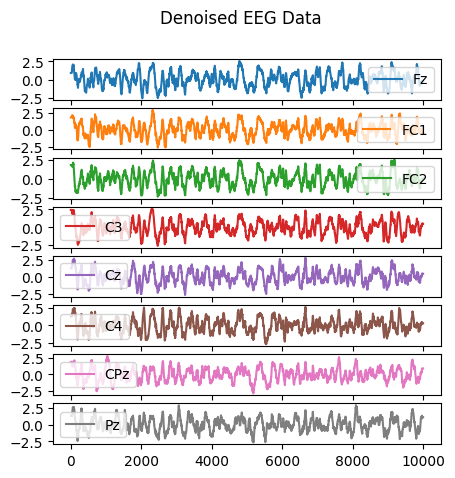

(10000, 8)


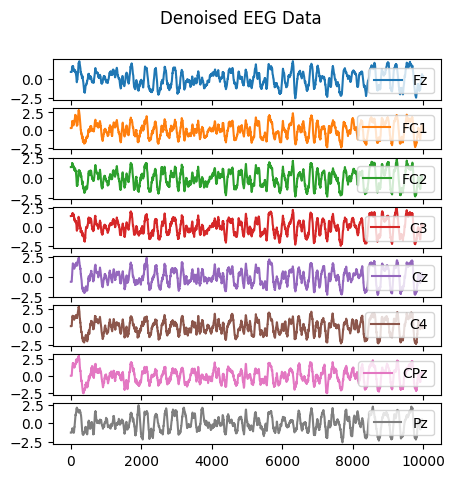

(10000, 8)


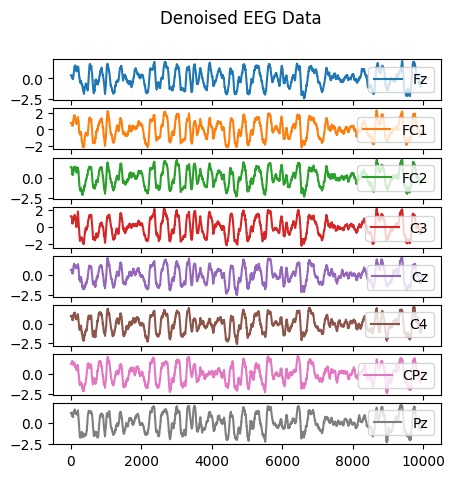

(10000, 8)


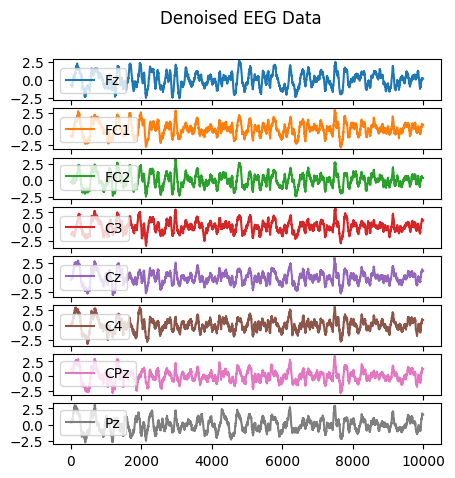

(10000, 8)


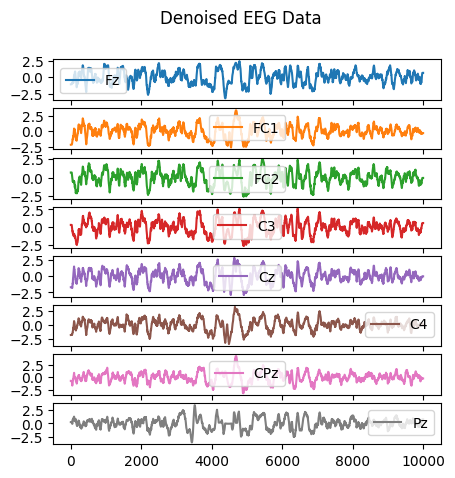

(10000, 8)


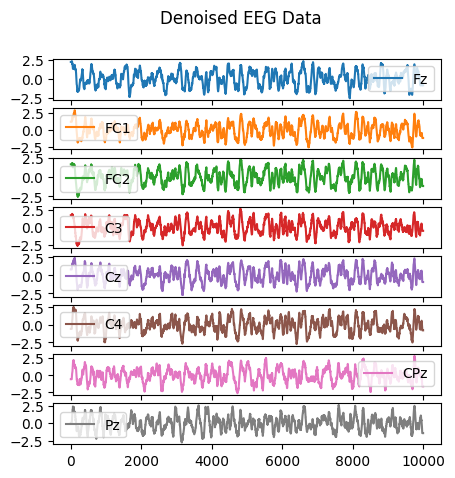

(10000, 8)


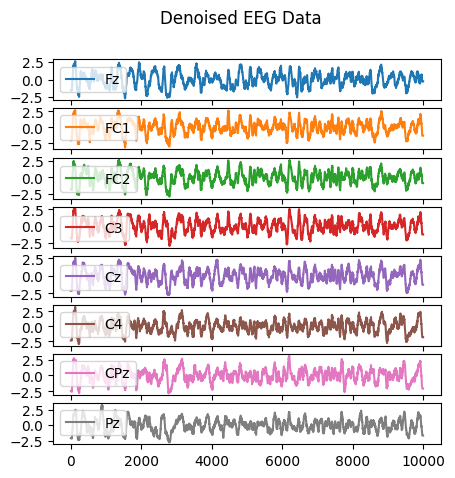

(10000, 8)


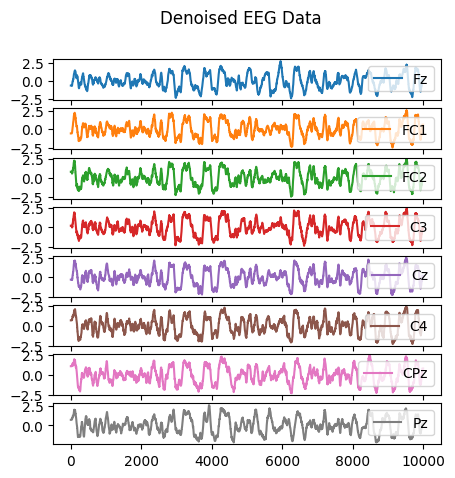

In [157]:
folder_name = 'f'
selected_columns = ['Fz', 'FC1', 'FC2', 'C3', 'Cz', 'C4', 'CPz', 'Pz']
duration = 40 
raw=[]
event=[]
BP=[]
PP=[]
if os.path.exists(folder_name) and os.path.isdir(folder_name):
    for file_name in os.listdir(folder_name):
        if file_name.endswith('.csv'):
            file_path = os.path.join(folder_name, file_name)
            s_temp = pd.read_csv(file_path, header=None)
            inst = s_temp.iloc[:, 17]
            df_temp = s_temp.iloc[:, :8]
            # print(df_temp.shape)
            # df_temp.plot(figsize=(10, 8))
            # plt.show()
            raw.append(df_temp)
            event.append(inst)
            
            # 1. Band Pass
            raw_bp = np.copy(df_temp)
            for column in range(8):
                raw_bp[:, column] = butter_bandpass_filter(raw_bp[:, column], lowcut=.4, highcut=40, fs=250) 
            print(raw_bp.shape)
            # plt.plot(raw_bp)
            # plt.show()
            
            # 2. Artifact rejection
            BP_artifact_RJ = np.copy(raw_bp)
            for channel in range (8):
                BP_artifact_RJ= reject_artifacts(pd.DataFrame(BP_artifact_RJ), channel)
            # plt.plot(BP_artifact_RJ)
            # plt.show()
            
            # # 3. Smoothing
            # BP_artifact_RJ_SM=BP_artifact_RJ.copy()
            # window_size = 10 
            # for channel in range (8):
            #     # channel_data = BP_artifact_RJ_SM[channel, :]
            #     BP_artifact_RJ_SM= BP_artifact_RJ_SM.rolling(window=window_size, center=True).mean().fillna(method='bfill').fillna(method='ffill')
            # # plt.plot(BP_artifact_RJ_SM)
            # # plt.show()
            # BP.append(BP_artifact_RJ_SM)
            
            # 4. Denoising and other preprocessing
            BP_artifact_RJ.columns = selected_columns
            eeg_df_denoised = preprocess(pd.DataFrame(BP_artifact_RJ), col_names=selected_columns, n_clusters=[50]*len(selected_columns))
            eeg_df_denoised.plot(subplots=True, figsize=(5, 5), title='Denoised EEG Data')
            plt.show()
            PP.append(eeg_df_denoised)

In [158]:
fs=250
B_N=int(len(PP)) #Number of blocks
PP_NP=np.array(PP) #shape: (B_N, 10000, 8=Channel Numbers)
event=np.array(event).reshape(B_N*(df_temp.shape[0]), 1) # df_temp.shape[0]=10000
denoised=PP_NP.reshape(B_N*(df_temp.shape[0]), 8) # seprate each blocks' signal 
pp_sig_event=np.concatenate((denoised, event), axis=1) 
labels=[] 
face = [] #lable=0
scene=[]#lable=1
# Aassuming correctness for the human behavior
for i in range(len(pp_sig_event)): #len(pp_sig_event) = the whole sample points, (df_temp.shape[0]*B_N)
    if 'M' in pp_sig_event[i, 8] or 'F' in pp_sig_event[i, 8]:
        face.append(pp_sig_event[i])
        labels.append(0)
    else:
        scene.append(pp_sig_event[i]) 
        labels.append(1)        
face = np.array(face)
scene = np.array(scene)
labels=np.array(labels) 
                 
print('event', event.shape,  'denoised',  denoised.shape, 'pp_sig_event', pp_sig_event.shape, 'face', face.shape, 'scene', scene.shape, 'labels', labels.shape)  
#denoised is all the denoised data with shape: (df_temp.shape[0]*B_N, 8)     
# event is all the events with shape: (df_temp.shape[0]*B_N, 1)                                                                                                            

event (80000, 1) denoised (80000, 8) pp_sig_event (80000, 9) face (30000, 9) scene (50000, 9) labels (80000,)


In [159]:
label=labels.reshape(int(labels.shape[0]/fs), fs)
Y=np.squeeze(label[:,0])

frequency_bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 14),
    'beta': (14, 30),
    'gamma': (30, 40),
     }

def apply_bandpass_filter(signal, lowcut, highcut, fs, order=5):
    nyquist = 0.5 * fs
    low = lowcut / nyquist
    high = highcut / nyquist
    b, a = butter(order, [low, high], btype='band')
    filtered_signal = filtfilt(b, a, signal)
    return filtered_signal
denoised_reshaped = denoised.reshape(int(denoised.shape[0]/250), 250, 8)


In [160]:
mlp_data=denoised_reshaped.reshape(denoised_reshaped.shape[0], denoised_reshaped.shape[1]*denoised_reshaped.shape[2])
print(mlp_data.shape)

af_mlp=mlp_data
Y_mlp=np.squeeze(label[:,0])
af_mlp, Y_mlp= shuffle(af_mlp, Y_mlp)
print(af_mlp.shape, Y_mlp.shape)
# Balance the dataset
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_resampled_mlp, y_resampled_mlp = oversampler.fit_resample(af_mlp, Y_mlp)
X_resampled_mlp= X_resampled_mlp.astype(np.float32)
y_resampled_mlp = y_resampled_mlp.astype(np.int32)


X_train_mlp, X_test_mlp, y_train_mlp, y_test_mlp = train_test_split(X_resampled_mlp,y_resampled_mlp, test_size=0.1, random_state=42)


(320, 2000)
(320, 2000) (320,)


In [ ]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout

# # Given data (You'd already have this loaded)
# # X_train, y_train, X_test, y_test

# # Ensure your target (y_train and y_test) is properly shaped.
# # For binary classification, it should be of shape (n_samples, 1)
# # For multi-class single-label classification, it should be one-hot encoded.

# # Define the MLP model
# model = Sequential()

# # Input layer (with relu activation and input shape matching your feature count)
# model.add(Dense(256, activation='relu', input_shape=(2000,)))

# # Hidden layers
# model.add(Dropout(0.4))
# model.add(Dense(250, activation='relu'))
# # model.add(Dropout(0.4))
# # model.add(Dense(64, activation='relu'))

# # Output layer
# # For binary classification, use 1 neuron with sigmoid activation
# # For multi-class classification, use softmax activation and change units to number of classes
# model.add(Dense(1, activation='sigmoid'))

# # Compile the model
# # For binary classification, use binary_crossentropy
# # For multi-class classification, use categorical_crossentropy
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the model
# model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=32, validation_data=(X_test_mlp, y_test_mlp))


In [80]:
# # Continue from the previously mentioned code
# # Evaluate the model on the training set
# train_loss, train_accuracy = model.evaluate(X_train_mlp, y_train_mlp, verbose=0)
# print(f"Training Accuracy: {train_accuracy * 100:.2f}%")

# # Evaluate the model on the test set
# test_loss, test_accuracy = model.evaluate(X_test_mlp, y_test_mlp, verbose=0)
# print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


Training Accuracy: 99.65%
Test Accuracy: 50.00%


In [161]:
import optuna
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split


def objective(trial):
    # Layers and neurons
    n_layers = trial.suggest_int('n_layers', 1,4)
    layers = []
    for i in range(n_layers):
        layers.append(trial.suggest_int(f'n_units_layer{i}', 16,  512))
    
    # Activation function
    activation = trial.suggest_categorical('activation', ['relu', 'logistic', 'tanh', 'identity'])
    
    # Learning rate
    learning_rate_init = trial.suggest_float('learning_rate_init', 1e-4,  1e-1, log=True)
    
    max_iter = trial.suggest_int('max_iter', 50, 1000)

    model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                          activation=activation, 
                          learning_rate_init=learning_rate_init,
                          max_iter=max_iter ,  # to ensure convergence in most cases
                          random_state=42)

    model.fit(X_train_mlp, y_train_mlp)

    # Evaluate
    predictions = model.predict(X_test_mlp)
    accuracy = accuracy_score(y_test_mlp, predictions)
    return accuracy

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=70)

print('Number of finished trials: ', len(study.trials))
print('Best trial:')
trial = study.best_trial
print('  Value: ', trial.value)
print('  Params: ')
for key, value in trial.params.items():
    print(f'    {key}: {value}')


[I 2023-10-14 14:46:32,900] A new study created in memory with name: no-name-4ea91543-73f5-4298-a8ae-a62e9197a04d
[I 2023-10-14 14:46:34,485] Trial 0 finished with value: 0.5 and parameters: {'n_layers': 3, 'n_units_layer0': 385, 'n_units_layer1': 292, 'n_units_layer2': 250, 'activation': 'tanh', 'learning_rate_init': 0.07927713155349757, 'max_iter': 336}. Best is trial 0 with value: 0.5.
[I 2023-10-14 14:46:42,448] Trial 1 finished with value: 0.775 and parameters: {'n_layers': 1, 'n_units_layer0': 473, 'activation': 'tanh', 'learning_rate_init': 0.00020311394965557208, 'max_iter': 384}. Best is trial 1 with value: 0.775.
[I 2023-10-14 14:46:45,267] Trial 2 finished with value: 0.65 and parameters: {'n_layers': 4, 'n_units_layer0': 228, 'n_units_layer1': 156, 'n_units_layer2': 420, 'n_units_layer3': 447, 'activation': 'tanh', 'learning_rate_init': 0.022053346475345997, 'max_iter': 349}. Best is trial 1 with value: 0.775.
[I 2023-10-14 14:46:46,684] Trial 3 finished with value: 0.775 a

Number of finished trials:  70
Best trial:
  Value:  0.9
  Params: 
    n_layers: 2
    n_units_layer0: 206
    n_units_layer1: 433
    activation: logistic
    learning_rate_init: 0.008164492483736336
    max_iter: 838


In [162]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Extract the best parameters
best_params = study.best_params

# Extract individual parameters
n_layers = best_params['n_layers']
layers = [best_params[f'n_units_layer{i}'] for i in range(n_layers)]
activation = best_params['activation']
learning_rate_init = best_params['learning_rate_init']
max_iter = best_params['max_iter']

# Create the model using the best parameters
best_model = MLPClassifier(hidden_layer_sizes=tuple(layers), 
                           activation=activation, 
                           learning_rate_init=learning_rate_init,
                           max_iter=max_iter ,  # to ensure convergence in most cases
                           random_state=42)

# Train the model using training data
best_model.fit(X_train_mlp, y_train_mlp)

# Predict using the test data
predictions = best_model.predict(X_test_mlp)


# Predict using the training data
train_predictions = best_model.predict(X_train_mlp)

# Evaluate the model using training data
train_accuracy = accuracy_score(y_train_mlp, train_predictions)
print(f"Training Accuracy: {train_accuracy:.4f}")


# Evaluate the model using test data
accuracy = accuracy_score(y_test_mlp, predictions)
print(f"Test Accuracy: {accuracy:.4f}")


Training Accuracy: 1.0000
Test Accuracy: 0.9000


In [116]:
# import optuna
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# def objective(trial):
#     model = Sequential()
#     # Input layer
#     n_units_i = trial.suggest_int('n_units_i', 128, 512)
#     model.add(Dense(n_units_i, activation='relu', input_shape=(2000,)))
#     # Hidden layers
#     dropout_rate_1 = trial.suggest_float('dropout_rate_1', 0.1, 0.6)
#     model.add(Dropout(dropout_rate_1))
#     n_units_h1 = trial.suggest_int('n_units_h1', 32, 256)
#     model.add(Dense(n_units_h1, activation='relu'))
#     dropout_rate_2 = trial.suggest_float('dropout_rate_2', 0.1, 0.6)
#     model.add(Dropout(dropout_rate_2))
#     n_units_h2 = trial.suggest_int('n_units_h2', 16, 128)
#     model.add(Dense(n_units_h2, activation='relu'))
#     # Output layer
#     model.add(Dense(1, activation='sigmoid'))
#     # Compile the model
#     lr = trial.suggest_float('lr', 1e-3, 1e-1, log=True)
#     optimizer = Adam(learning_rate=lr)
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
#     # Train the model
#     model.fit(X_train_mlp, y_train_mlp, epochs=100, batch_size=64, validation_data=(X_test_mlp, y_test_mlp), verbose=0)
#     # Evaluate the model
#     score = model.evaluate(X_test_mlp, y_test_mlp, verbose=0)
#     return score[1]  # Return accuracy
# study = optuna.create_study(direction='maximize')
# study.optimize(objective, n_trials=20)
# print('Number of finished trials: ', len(study.trials))
# print('Best trial:')
# trial = study.best_trial
# print('  Value: ', trial.value)
# print('  Params: ')
# for key, value in trial.params.items():
#     print(f'    {key}: {value}')


[I 2023-10-14 14:04:19,432] A new study created in memory with name: no-name-38071058-c379-4c98-bc92-5521cc07b1ec
[I 2023-10-14 14:04:24,851] Trial 0 finished with value: 0.59375 and parameters: {'n_units_i': 220, 'dropout_rate_1': 0.4604194999622985, 'n_units_h1': 162, 'dropout_rate_2': 0.15008127922277684, 'n_units_h2': 117, 'lr': 0.001084045276968205}. Best is trial 0 with value: 0.59375.
[I 2023-10-14 14:04:31,996] Trial 1 finished with value: 0.59375 and parameters: {'n_units_i': 479, 'dropout_rate_1': 0.15479312816685095, 'n_units_h1': 215, 'dropout_rate_2': 0.29033845702401284, 'n_units_h2': 16, 'lr': 0.0029068951230053893}. Best is trial 0 with value: 0.59375.
[I 2023-10-14 14:04:37,351] Trial 2 finished with value: 0.59375 and parameters: {'n_units_i': 279, 'dropout_rate_1': 0.29702015827014416, 'n_units_h1': 106, 'dropout_rate_2': 0.4746165910903912, 'n_units_h2': 45, 'lr': 0.006785089288374672}. Best is trial 0 with value: 0.59375.
[I 2023-10-14 14:04:45,296] Trial 3 finishe

Number of finished trials:  20
Best trial:
  Value:  0.75
  Params: 
    n_units_i: 294
    dropout_rate_1: 0.5350895405431693
    n_units_h1: 79
    dropout_rate_2: 0.3873433313045219
    n_units_h2: 91
    lr: 0.015609078350217189


In [117]:
# import numpy as np
# import tensorflow as tf
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, Dropout
# from tensorflow.keras.optimizers import Adam

# # Function to define and compile the model based on hyperparameters
# def create_model(n_units_i, dropout_rate_1, n_units_h1, dropout_rate_2, n_units_h2, lr):
#     model = Sequential()
    
#     # Input layer
#     model.add(Dense(n_units_i, activation='relu', input_shape=(2000,)))

#     # Hidden layers
#     model.add(Dropout(dropout_rate_1))
#     model.add(Dense(n_units_h1, activation='relu'))
#     model.add(Dropout(dropout_rate_2))
#     model.add(Dense(n_units_h2, activation='relu'))

#     # Output layer
#     model.add(Dense(1, activation='sigmoid'))

#     # Compile the model
#     optimizer = Adam(learning_rate=lr)
#     model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#     return model

# # Using the best hyperparameters found by Optuna
# best_params = study.best_params
# best_model = create_model(
#     best_params['n_units_i'], 
#     best_params['dropout_rate_1'], 
#     best_params['n_units_h1'], 
#     best_params['dropout_rate_2'], 
#     best_params['n_units_h2'], 
#     best_params['lr']
# )

# # Train the model using the entire training dataset
# best_model.fit(X_train_mlp, y_train_mlp, epochs=50, batch_size=64, validation_data=(X_test_mlp, y_test_mlp))

# # Evaluate the model using the test dataset
# loss, accuracy = best_model.evaluate(X_test_mlp, y_test_mlp)

# print(f"Test Loss: {loss:.4f}")
# print(f"Test Accuracy: {accuracy*100:.2f}%")


Epoch 1/50
5/5 [==============================] - 1s 33ms/step - loss: 7.4861 - accuracy: 0.5139 - val_loss: 2.9239 - val_accuracy: 0.3438
Epoch 2/50
5/5 [==============================] - 0s 16ms/step - loss: 2.2552 - accuracy: 0.5278 - val_loss: 0.5973 - val_accuracy: 0.6250
Epoch 3/50
5/5 [==============================] - 0s 16ms/step - loss: 1.1619 - accuracy: 0.5243 - val_loss: 0.7301 - val_accuracy: 0.5938
Epoch 4/50
5/5 [==============================] - 0s 16ms/step - loss: 1.0126 - accuracy: 0.5486 - val_loss: 0.7150 - val_accuracy: 0.5625
Epoch 5/50
5/5 [==============================] - 0s 15ms/step - loss: 0.7577 - accuracy: 0.5590 - val_loss: 0.7238 - val_accuracy: 0.5625
Epoch 6/50
5/5 [==============================] - 0s 16ms/step - loss: 0.9086 - accuracy: 0.5451 - val_loss: 0.7838 - val_accuracy: 0.5625
Epoch 7/50
5/5 [==============================] - 0s 16ms/step - loss: 0.8416 - accuracy: 0.4965 - val_loss: 0.7104 - val_accuracy: 0.5000
Epoch 8/50
5/5 [===========